https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def draw_sample(image, mask, classes, is_tensor=False):

    gray_mask = []
    if is_tensor:
        mask = mask.permute(1, 2, 0)
        image = image.permute(1, 2, 0)

    for line in mask:
        for pix in line:
            gray_mask.append(classes[np.argmax(pix)])

    gray_mask = np.reshape(gray_mask, (mask.shape[0], mask.shape[1]))

    # print("classes: {}".format(np.unique(gray_mask)))

    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")

    plt.subplot(1, 2, 2)
    plt.imshow(gray_mask, cmap='gray', vmin=0, vmax=255)
    # plt.imshow(gray_mask)
    plt.title(f"Mask")

In [3]:
ROOT = Path("./data/heads/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"

# ROOT = Path("./data/CelebA-HQ/")
#
# train_image_path = ROOT / "CelebA-HQ-img"
# train_mask_path = ROOT / "mask"

In [4]:
# ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
# ALL_IMAGES = ALL_IMAGES[:5000]
# ALL_MASKS = ALL_MASKS[:5000]

In [5]:
from typing import List
from catalyst import utils

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        classes,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.n_classes = len(classes)
        self.classes = classes

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        # print(image_path)
        image = utils.imread(image_path)
        result = {"image": image}

        if self.masks is not None:
            # mask = cv2.imread(str(self.masks[idx]), 0)
            mask = utils.imread(str(self.masks[idx]))
            mask = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
            # cv2.imshow('dfsd', mask)
            # cv2.waitKey(0)
            one_hot = np.zeros((mask.shape[0], mask.shape[1], self.n_classes))
            for i, unique_value in enumerate(self.classes):
                one_hot[:, :, i][mask == unique_value] = 1
            result["mask"] = one_hot

        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name

        return result

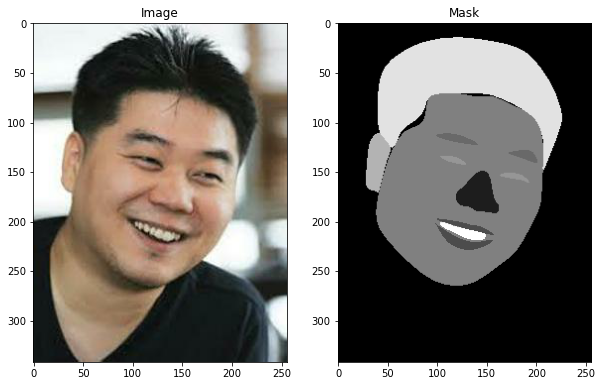

In [6]:
CLASSES = [0, 29, 76, 105, 128, 150, 179, 211, 226, 255]
dataset = SegmentationDataset(CLASSES, ALL_IMAGES, ALL_MASKS)
#
sample = dataset[0]
draw_sample(sample["image"], sample["mask"], CLASSES)
# print(sample["image"], sample["mask"].shape)

In [7]:
import albumentations as albu
from albumentations.pytorch import ToTensor, ToTensorV2

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]

# def post_transforms():
#     return [normalize, ToTensor(num_classes=9)]

# def post_transforms():
#     return [albu.Normalize(), ToTensor(num_classes=9)]

# def post_transforms():
#     return [ToTensor(num_classes=9)]

def post_transforms():
    return [
        albu.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225), p=1),
        ToTensor(num_classes=len(CLASSES))
    ]


def hard_transforms():
    result = [
      # albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.1, contrast_limit=0.1, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      # albu.HueSaturationValue(p=0.3)
    ]

    return result
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [9]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(),
    post_transforms(),
])
valid_transforms = compose([pre_transforms(), post_transforms()])
visualize_transforms = compose([pre_transforms(), hard_transforms()])

In [10]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And expect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [11]:
batch_size = 12
random_state = 4

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=random_state,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [12]:
dataloader_iterator = iter(loaders["train"])
a = next(dataloader_iterator)

In [13]:
# print(a["image"].shape)
# for i in range (min(len(a["image"])-1, 4)):
#     draw_sample(a["image"][i], a["mask"][i], CLASSES, is_tensor=True)
#     print(a["mask"][i].shape)

In [14]:
import segmentation_models_pytorch as smp
# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
# model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)
# aux_params = dict(pooling = 'avg',
#                   dropout = 0.5,
#                   activation = None,
#                   classes = len(CLASSES)
#                   )

# aux_params = dict(pooling = 'avg',
#                   dropout = 0.5,
#                   # activation = None,
#                   classes = len(CLASSES)
#                   )
aux_params= None
# model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights='imagenet', classes=len(CLASSES), aux_params=aux_params)
# model = smp.FPN(encoder_name="inceptionv4", encoder_weights='imagenet', classes=len(CLASSES), aux_params=aux_params)
# model = smp.FPN(encoder_name="inceptionv4", classes=len(CLASSES), aux_params=aux_params)
model = smp.FPN(encoder_name="efficientnet-b4", decoder_dropout=0.5, classes=len(CLASSES), aux_params=aux_params)
# model = smp.FPN(encoder_name="mobilenet_v2", encoder_weights='imagenet', classes=len(CLASSES), aux_params=aux_params)

In [15]:
# from torchsummary import summary
# summary(model, (3, 224, 224))

In [16]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss(),
    "focal": FocalLossBinary()
    # TODO change to MultyClass
}
#https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/14

In [17]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
# weight_decay - parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.0001)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
learning_rate = 0.001
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0001)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [18]:
from catalyst.dl import SupervisedRunner

num_epochs = 30
logdir = "./logs/segmentation/efficientnet-b4"

device = utils.get_device()
print(f"device: {device}")

# if is_fp16_used:
#     fp16_params = dict(opt_level="O1") # params for FP16
# else:
#     fp16_params = None

# print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [19]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_focal",
        criterion_key="focal"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 1.0, "loss_focal":1.0},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [20]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=None,
    # prints train logs
    verbose=True,
)

1/30 * Epoch (train): 100% 441/441 [03:28<00:00,  2.12it/s, dice=0.847, iou=0.734, loss=0.564, loss_bce=0.108, loss_dice=0.153, loss_focal=0.037, loss_iou=0.266]
1/30 * Epoch (valid): 100% 110/110 [00:29<00:00,  3.79it/s, dice=0.847, iou=0.734, loss=0.540, loss_bce=0.091, loss_dice=0.153, loss_focal=0.029, loss_iou=0.266]
[2020-09-20 23:25:33,298] 
1/30 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/30 * Epoch 1 (train): dice=0.6406 | iou=0.4980 | loss=1.2765 | loss_bce=0.2893 | loss_dice=0.3594 | loss_focal=0.1258 | loss_iou=0.5020
1/30 * Epoch 1 (valid): dice=0.8688 | iou=0.7689 | loss=0.4746 | loss_bce=0.0831 | loss_dice=0.1312 | loss_focal=0.0292 | loss_iou=0.2311
2/30 * Epoch (train): 100% 441/441 [03:21<00:00,  2.19it/s, dice=0.902, iou=0.822, loss=0.356, loss_bce=0.060, loss_dice=0.098, loss_focal=0.021, loss_iou=0.178]
2/30 * Epoch (valid): 100% 110/110 [00:26<00:00,  4.19it/s, dice=0.892, iou=0.805, loss=0.387, loss_bce=0.062, loss_dice=0.108, loss_focal=0.021, loss_iou=0.19

/home/kuskov/anaconda3/envs/otus_cv_cource/lib/python3.7/site-packages/catalyst/core/callbacks/optimizer.py:95: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)



In [21]:
# ls -lh ./logs/segmentation/checkpoints/

In [31]:
from pathlib import Path
ROOT = Path("data/heads/")
test_image_path = ROOT / "test"
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

In [32]:
# create test dataset
test_dataset = SegmentationDataset(
    CLASSES,
    TEST_IMAGES,
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(),
    runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth")
    # runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/train.1.exception_KeyboardInterrupt.pth")
)))

print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(13, 10, 224, 224)


(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)
(10, 224, 224)


/home/kuskov/anaconda3/envs/otus_cv_cource/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



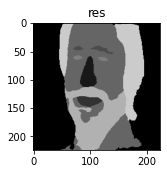

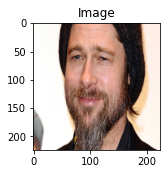

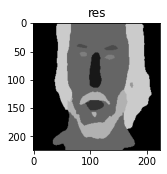

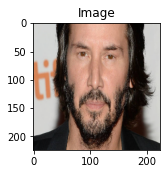

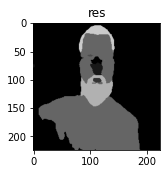

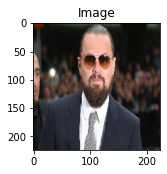

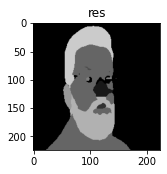

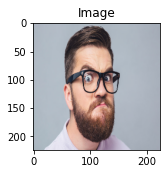

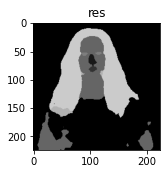

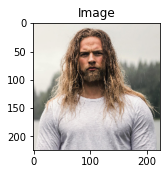

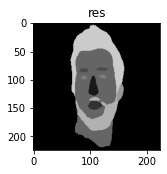

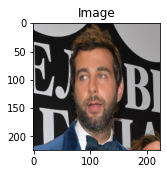

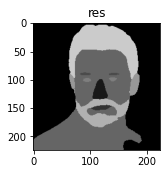

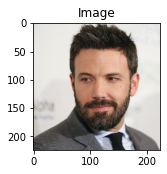

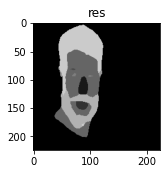

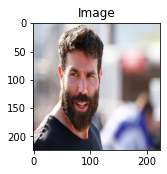

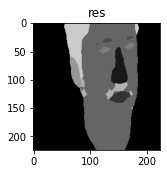

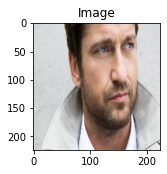

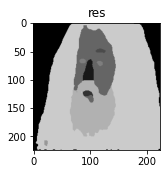

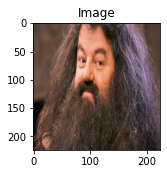

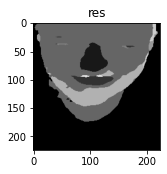

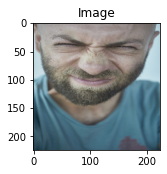

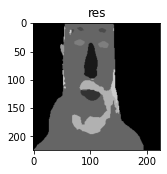

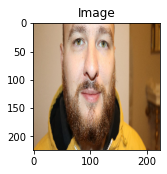

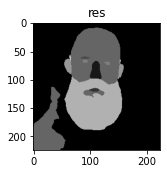

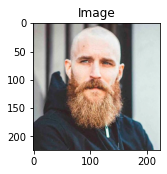

In [33]:
import torch
import numpy
# p = predictions[0].permute(1, 2, 0)
# print (p.shape)
import torch
max_count = 62
#
# masks = []
for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    # print(features["image"])
#     image = utils.tensor_to_ndimage(features["image"])
#
    # slices
    print(logits.shape)
    res = torch.argmax(torch.from_numpy(logits), dim=0)
    res = numpy.asarray(res)

    v = 255/len(CLASSES)
    res = res*v - 1
    res = res.astype("int")

    plt.figure(figsize=(5, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(res, cmap='gray', vmin=0, vmax=255)
    plt.title(f"res")

    # image is ok
    image = utils.tensor_to_ndimage(features["image"])
    plt.figure(figsize=(5, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")



    if i >= max_count:
        break
plt.show()
